# CLASSIFICATION MODEL: Text Analysis

>In this part of the content, we'll try to perform a sentiment analysis that will use employees' feedback and categorise them as either negative or positive. Then using that classification, we're going to build a predictive model that will allow us to see for each employee, if he is likely to change his sentiment, implementing a Binary Classification (Logistic Regression) . Finally, we'll evaluate our model using different metrics and we'll interpret the result.

In [1]:
import os
import sys

os.environ["JAVA_HOME"] = "JDK 8/Contents/Home"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, OneHotEncoder, VectorAssembler, StringIndexer, IDF,HashingTF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator,TrainValidationSplit, ParamGridBuilder




In [3]:

# Create a SparkSession
spark = SparkSession \
    .builder \
        .appName("GlassdoorAnalysis") \
            .getOrCreate()


25/02/22 09:56:17 WARN Utils: Your hostname, Toms-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.180.174.193 instead (on interface en0)
25/02/22 09:56:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/22 09:56:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 49171)
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/Library/Frameworks/Pyt

## Step 1: Extracting only the useful columns

In [4]:

path = "/Users/tomdursley/Documents/Pyspark Project/Pyspark tables/glassdoor.csv"
df = spark.read.csv(path, header=True, inferSchema=True)
df.show(5)



25/02/22 09:56:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+--------------------+-------------+
|ReviewId|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkL

In [5]:
glass_df = df.select("ReviewID", "Feedback")

glass_df.show(5)

+--------+--------------------+
|ReviewID|            Feedback|
+--------+--------------------+
|     100|People are willin...|
|     101|To repeat what I ...|
|     102|The variety of di...|
|     103|As youve probably...|
|     104|Great insurance b...|
+--------+--------------------+
only showing top 5 rows



## Step 2: Feature Engineering

We need to preprocess the text data before we can use it in our model. This involves tokenization, removing stop words, and converting the text to numerical features:

**1. Tokenization**

> Tokenisation is the process of separating text (such as a phrase) into distinct terms (typically words). This functionality is provided by the basic feature transformer *Tokeniser* class. The following example demonstrates how to divide sentences into word sequences.

In [6]:

tokeniser = Tokenizer(inputCol="Feedback", outputCol="words")

tokenisedData = tokeniser.transform(glass_df)

tokenisedData.show(5, truncate=False)


+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ReviewID|Feedback                                                                                                                                                                                                                           |words                                                                                                                                                                                                                                                   

**2.  StopWordsRemover**

>Stop words are words that should be removed from the input, often because they appear frequently and contain little significance.

>The feature transformer *StopWordsRemover* takes a sequence of strings as input (for example, the output of a Tokeniser) and removes all stop words. The stopWords option specifies a list of stop words. >

In [7]:
remover = StopWordsRemover(inputCol="words", outputCol="cleaned_words")

removedWords = remover .transform(tokenisedData)

removedWords.show(5, truncate=False)

+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------+
|ReviewID|Feedback                                                                                                                                                                                                                           |words                                                                                                

**3.  HashingTF**

*HashingTF* is another feature that turns a collection of text documents into a fixed-size vector using the hashing method. It is especially beneficial when working with huge vocabularies since it reduces dimensionality while efficiently handling high-dimensional data.
***
**Use Cases:**

+ **Text Classification:** HashingTF is commonly used in text classification tasks where the high-dimensional data needs to be efficiently managed.

+ **Real-Time Processing:** Suitable for real-time text processing systems due to its computational efficiency and fixed-size output.

+ **Scalability:** Handles very large datasets effectively without needing to maintain a dynamic vocabulary.
***

**4.  CountVectorizer**

>*CountVectorizer* is a feature extractor that transforms a set of text documents (each row) into a vector of token counts. This method is critical in natural language processing (NLP) and text mining because it converts textual input into numerical data that can be fed into machine learning algorithms. *CountVectorizer* converts text data into vectors that indicate the frequency of each word or character in the dataset.
***
>**Use Cases:**

+ ***Text Classification:*** CountVectorizer is commonly used in text classification tasks where the frequency of words is an important feature.

+ ***Clustering Text Data:*** It helps in clustering text documents based on word frequencies.

+ ***Feature Extraction:*** It is also used in feature extraction from text data for various NLP tasks.
***

In [8]:
count_vectoriser = CountVectorizer(inputCol="cleaned_words", outputCol="raw_features")

vectorisedModel = count_vectoriser.fit(removedWords)

vectorisedData = vectorisedModel.transform(removedWords)

vectorisedData.show(5, truncate=False)

+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+
|ReviewID|Feedback                                                                                                                                                                          

**5.  IDF**

>*IDF* (Inverse Document Frequency) is an Estimator which is fit on a dataset and produces an IDFModel. The IDFModel takes feature vectors (generally created from HashingTF or CountVectorizer) and scales each feature. Intuitively, it down-weights features which appear frequently in a corpus.

In [9]:
idf = IDF(inputCol="raw_features", outputCol="idf_features")
idfModel = idf.fit(vectorisedData)

idfData = idfModel.transform(vectorisedData)

idfData.show(5, truncate=False)

+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Step 3: Labeling the Data

>For sentiment analysis, we need labeled data. Since we don't have pre-existing labels, we'll use a simple heuristic approach to create labels based on the presence of positive or negative words:

In [10]:
# Define lists of positive and negative words
positive_words = [
    "good", "great", "excellent", "happy", "satisfied", "wonderful", "fantastic",
    "amazing", "productive", "supportive", "innovative", "motivating", "friendly",
    "collaborative", "rewarding", "engaging", "inclusive", "flexible", "enjoyable",
    "inspiring", "nurturing", "thriving", "efficient", "professional", "respectful",
    "transparent", "empowering", "appreciative", "dynamic", "successful", "positive",
    "harmonious", "team-oriented", "growth-oriented", "smart"
]

negative_words = [
    "bad", "poor", "terrible", "unhappy", "dissatisfied", "awful", "horrible",
    "disappointing", "stressful", "unproductive", "toxic", "negative", "frustrating",
    "unmotivating", "unfair", "inefficient", "disrespectful", "hostile", "micromanaged",
    "unappreciated", "undervalued", "overworked", "underpaid", "chaotic", "disorganized",
    "political", "apathetic", "depressing", "uninspired", "isolating", "inflexible",
    "bureaucratic", "stagnant"
]


In [11]:
def label_sentiment(words):
    words = set(words)
    positive_count = sum(1 for word in positive_words if word in words)
    negative_count = sum(1 for word in negative_words if word in words)
    return 1 if positive_count >negative_count else 0


label_sentiment_udf = udf(label_sentiment, IntegerType())

labeled_data = idfData.withColumn("label", label_sentiment_udf("cleaned_words"))



In [12]:
labeled_data.show(5, truncate=False)



+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Step 4: Splitting the Data

>The training set will be used to train the model, and the testing set will be used to evaluate the model's performance.



In [13]:

train_data, test_data = labeled_data.randomSplit([0.8, 0.2], seed=42)



## Step 5: Model Training

>Now we'll train a logistic regression model:

In [14]:
logistic_reg = LogisticRegression(featuresCol="idf_features", labelCol="label")

logist_model = logistic_reg.fit(train_data)


25/02/22 09:56:41 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [15]:
logist_prediction = logist_model.transform(test_data)

In [16]:
logist_prediction.show(truncate=False)

+--------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------

## Step 6: Evaluation of the model

>**Using the AUC (Area Under the ROC Curve) metric**

***
The AUC (Area Under the ROC Curve) in logistic regression is an important metric for assessing the performance of a binary classification model. It evaluates the model's ability to differenciate between positive and negative classes.
***
**How to interpret AUC?**

+ AUC = 1: Perfect model. The model distinguishes perfectly between positive and negative classes.

+ 0.5 < AUC < 1: Good model. The model performs better than random guessing.

+ AUC = 0.5: Random guessing. The model has no discriminatory power.

+ AUC < 0.5: Worse than random guessing. The model's predictions are inversely correlated with the actual class.
***
**What AUC Measures?**

+ *AUC (Area Under the Curve):* It represents the area under the ROC curve. AUC quantifies the overall ability of the model to discriminate between positive and negative classes.

+ *Range:* AUC values range from 0 to 1. A higher AUC indicates better model performance.
***

In [17]:
logist_evaluator = BinaryClassificationEvaluator(labelCol="label",
                                                 rawPredictionCol= "rawPrediction", 
                                                 metricName = "areaUnderROC")

logist_perform = logist_evaluator.evaluate(logist_prediction)

print("The model performance is: ", logist_perform)

The model performance is:  0.84472049689441


> **Using the Accuracy metric**

***
Accuracy is defined as the proportion of accurately predicted occurrences (including true positives and true negatives) to the total number of instances. It provides a generic measure of how frequently the model generates correct predictions.

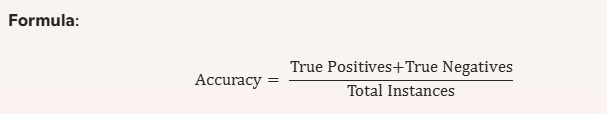

***
**How to interpret ?**

+ *High Accuracy:* Indicates that the model is making more correct predictions.

+ *Use Case:* In a balanced dataset of animal images, accuracy can measure how well a model correctly identifies different species
***

In [37]:
true_positive = logist_prediction.filter((F.col("label") == 1) & (F.col("prediction") == 1)).count()
true_negative = logist_prediction.filter((F.col("label") == 0) & (F.col("prediction") == 0)).count()


#doing the below for further use
false_positive = logist_prediction.filter((F.col("label") == 0) & (F.col("prediction") == 1)).count()
false_negative = logist_prediction.filter((F.col("label") == 1) & (F.col("prediction") == 0)).count()

print(f"The true positive is: {true_positive}")
print(f"The true negative is: {true_negative}")

Total_instances = true_negative + true_positive + false_negative + false_positive

print(f"The total instances is: {Total_instances}")

print("(20 + 40)/74 = accuracy")

accuracy = (true_negative + true_positive)/Total_instances

print(f"The accuracy of the model is: {accuracy*100}")



The true positive is: 20
The true negative is: 40
The total instances is: 74
(20 + 40)/74 = accuracy
The accuracy of the model is: 81.08108108108108


>**Using the Precision metric**

***
Precision is the fraction of genuine positive predictions among all positive predictions (including true and false positives). It displays how accurate the model's favourable predictions are.

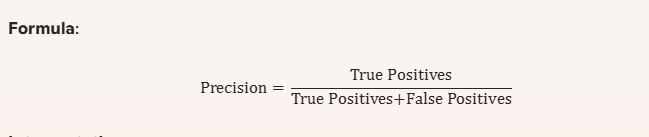

***
**How to interpret ?**

+ *High Precision:* Indicates that the model makes very few false positive predictions, meaning it is good at identifying positive instances.

+ *Use Case:* Precision is particularly useful in situations where the cost of false positives is high. For example, in spam detection, you want to minimise the number of legitimate emails incorrectly classified as spam.
***

In [41]:

precision = true_positive/(true_positive+false_positive)

print(f"Precision is calculated by {true_positive} / ({true_positive} + {false_negative}) = {precision*100}")



Precision is calculated by 20 / (20 + 8) = 76.92307692307693


>**Using the Recall (Sensitivity or True Positive Rate) Metric**

***
Recall quantifies the fraction of true positive cases properly detected by the model. It is especially beneficial when you wish to reduce false negatives while still detecting the majority of true positives.


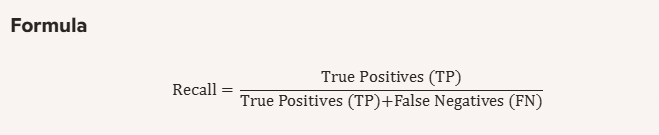

***
**How to interpret ?**

+ *High Recall:* Indicates that the model successfully identifies most of the actual positive instances. This is crucial in applications where missing a positive instance (false negative) is costly, such as in medical diagnosis or fraud detection.

+ *Low Recall:* Indicates that the model fails to identify many positive instances, resulting in a higher number of false negatives.
***

**Use Cases**

Medical Diagnosis: In diseases screening tests, recall is crucial because missing a diseased patient (false negative) can have serious consequences.

Spam Detection: Recall is important to ensure that most spam emails are correctly identified, even if it means a few legitimate emails are incorrectly classified as spam.

Fraud Detection: High recall helps in detecting most fraudulent transactions to prevent financial losses.

In [43]:

Recall = true_positive/(true_positive+false_negative)

print(f"Recall is calculated by {true_positive} / ({true_positive} + {false_negative}) = {Recall*100}")




Recall is calculated by 20 / (20 + 8) = 71.42857142857143


>**Using the F1-score Metric**

***
The F1 score is a metric that combines precision and recall into a single value, providing a more balanced assessment of a model's accuracy. It is especially beneficial when dealing with unbalanced datasets or weighing the significance of precision over recall.

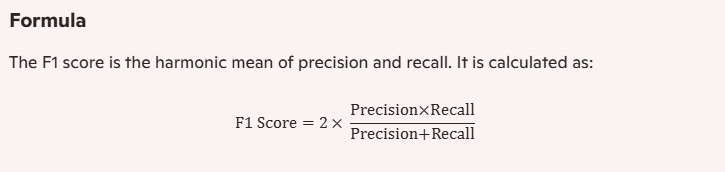

In [46]:
F1_Score = (2*(precision*Recall))/(precision+Recall)
    
print(f"F1 Score is calculated by ({2*(precision*Recall)}) / ({precision} + {Recall}) = {F1_Score*100}")


F1 Score is calculated by (1.098901098901099) / (0.7692307692307693 + 0.7142857142857143) = 74.07407407407408


25/02/22 12:38:47 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 691262 ms exceeds timeout 120000 ms
25/02/22 12:38:47 WARN SparkContext: Killing executors is not supported by current scheduler.
25/02/22 12:38:52 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

***
**How to interpret ?**

+ *Range:* The F1 score ranges from 0 to 1, where 1 indicates perfect precision and recall, and 0 indicates the worst performance.

+ *Balanced Measure:* The F1 score is useful when you need a single metric that balances the trade-offs between precision and recall, particularly in cases of uneven class distribution.

***
**Use Cases:**

Imbalanced Datasets: The F1 score is especially useful for imbalanced datasets where the number of true negatives is much higher than the number of true positives.

Classification Tasks: It is widely used in binary classification tasks where both precision and recall are important.
***

In [18]:

df.show(5)



+--------+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+--------------------+-------------+
|ReviewId|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkL

EXERCISE: Create a classification model that will allow you to predict whether an employee will be subject to attrition in the future, using relevant columns, and evaluate your model using a relevant metric.